In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_DO(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=5, filters=64, strides=1, padding='same', 
                      kernel_initializer='he_uniform', input_shape=input_shape)) 
    model.add(Activation('relu'))
#     model.add(MaxPooling1D(pool_size=3, strides=3, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=5, filters=64*(2**int((i+1)/4)), 
                          strides=1, padding='same', kernel_initializer='he_uniform'))
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.5))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_DO(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         384       
_________________________________________________________________
activation (Activation)      (None, 16000, 64)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,384,400
Trainable params: 16,384,400
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_15 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_16 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_17 (Activation)   (None, 5333, 64)          0         
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_36 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_37 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_38 (Activation)   (None, 5333, 64)          0         
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9296 - acc: 0.3972
Epoch 00001: val_loss improved from inf to 1.52296, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_3_conv_checkpoint/001-1.5230.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.9296 - acc: 0.3972 - val_loss: 1.5230 - val_acc: 0.5351
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3306 - acc: 0.5909
Epoch 00002: val_loss improved from 1.52296 to 1.36017, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_3_conv_checkpoint/002-1.3602.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 1.3306 - acc: 0.5909 - val_loss: 1.3602 - val_acc: 0.5765
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.0709 - acc: 0.6735
Epoch 00003: val_loss improved from 1.36017 to 1.35445, savin

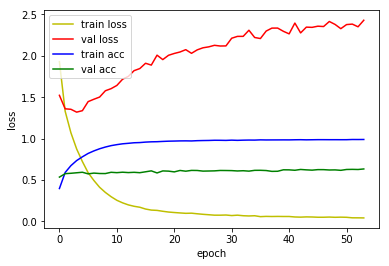

4815/4815 [==============================] - 3s 530us/sample - loss: 1.4107 - acc: 0.5529
Loss: 1.4106930673308091 Accuracy: 0.5528557

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9515 - acc: 0.3754
Epoch 00001: val_loss improved from inf to 1.40711, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_4_conv_checkpoint/001-1.4071.hdf5
36805/36805 [==============================] - 49s 1ms/sample - loss: 1.9516 - acc: 0.3754 - val_loss: 1.4071 - val_acc: 0.5709
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3392 - acc: 0.5805
Epoch 00002: val_loss improved from 1.40711 to 1.22253, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_4_conv_checkpoint/002-1.2225.hdf5
36805/36805 [==============================] - 48s 1ms/sample - loss: 1.3393 - acc: 0.5805 - val_loss: 1.2225 - val_acc: 0.6215
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1279 - acc: 0.9587
Epoch 00028: val_loss did not improve from 0.95018
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1279 - acc: 0.9587 - val_loss: 1.2112 - val_acc: 0.7442
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9603
Epoch 00029: val_loss did not improve from 0.95018
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1221 - acc: 0.9603 - val_loss: 1.2601 - val_acc: 0.7298
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1160 - acc: 0.9627
Epoch 00030: val_loss did not improve from 0.95018
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.1160 - acc: 0.9626 - val_loss: 1.2444 - val_acc: 0.7421
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1181 - acc: 0.9624
Epoch 00031: val_loss did not improve from 0.95018
36805/36805 [===========

Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9786
Epoch 00058: val_loss did not improve from 0.95018
36805/36805 [==============================] - 48s 1ms/sample - loss: 0.0707 - acc: 0.9786 - val_loss: 1.3714 - val_acc: 0.7591

1D_CNN_custom_he-uniform_DO_4_conv Model


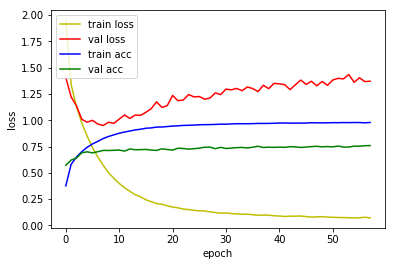

4815/4815 [==============================] - 3s 553us/sample - loss: 1.0678 - acc: 0.6733
Loss: 1.0678083244142502 Accuracy: 0.67331254

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.9160 - acc: 0.3856
Epoch 00001: val_loss improved from inf to 1.36921, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_5_conv_checkpoint/001-1.3692.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.9158 - acc: 0.3856 - val_loss: 1.3692 - val_acc: 0.5747
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2912 - acc: 0.5956
Epoch 00002: val_loss improved from 1.36921 to 1.08592, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_5_conv_checkpoint/002-1.0859.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 1.2911 - acc: 0.5956 - val_loss: 1.0859 - val_acc: 0.6720
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1379 - acc: 0.9556
Epoch 00027: val_loss did not improve from 0.71996
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1379 - acc: 0.9556 - val_loss: 0.8398 - val_acc: 0.8064
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1361 - acc: 0.9566
Epoch 00028: val_loss did not improve from 0.71996
36805/36805 [==============================] - 49s 1ms/sample - loss: 0.1361 - acc: 0.9566 - val_loss: 0.8886 - val_acc: 0.8027
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1280 - acc: 0.9579
Epoch 00029: val_loss did not improve from 0.71996
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.1280 - acc: 0.9579 - val_loss: 0.8104 - val_acc: 0.8106
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1266 - acc: 0.9601
Epoch 00030: val_loss did not improve from 0.71996
36805/36805 [===========

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0718 - acc: 0.9784
Epoch 00057: val_loss did not improve from 0.71996
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0718 - acc: 0.9784 - val_loss: 0.8722 - val_acc: 0.8293
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0656 - acc: 0.9801
Epoch 00058: val_loss did not improve from 0.71996
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0656 - acc: 0.9801 - val_loss: 0.9353 - val_acc: 0.8246
Epoch 59/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0667 - acc: 0.9796
Epoch 00059: val_loss did not improve from 0.71996
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0667 - acc: 0.9796 - val_loss: 0.9019 - val_acc: 0.8325
Epoch 60/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0688 - acc: 0.9783
Epoch 00060: val_loss did not improve from 0.71996
36805/36805 [===========

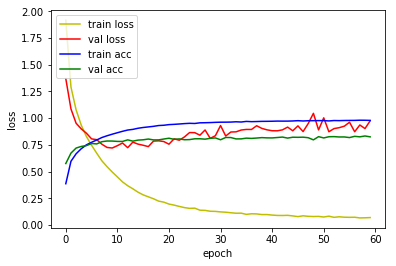

4815/4815 [==============================] - 3s 609us/sample - loss: 0.8189 - acc: 0.7466
Loss: 0.8188534947199242 Accuracy: 0.7466251

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.0260 - acc: 0.3452
Epoch 00001: val_loss improved from inf to 1.38156, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_6_conv_checkpoint/001-1.3816.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.0258 - acc: 0.3453 - val_loss: 1.3816 - val_acc: 0.5691
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.3407 - acc: 0.5764
Epoch 00002: val_loss improved from 1.38156 to 1.07189, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_6_conv_checkpoint/002-1.0719.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.3406 - acc: 0.5764 - val_loss: 1.0719 - val_acc: 0.6788
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2321 - acc: 0.9274
Epoch 00024: val_loss did not improve from 0.38585
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.2321 - acc: 0.9274 - val_loss: 0.3956 - val_acc: 0.9029
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2210 - acc: 0.9308
Epoch 00025: val_loss improved from 0.38585 to 0.37360, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_6_conv_checkpoint/025-0.3736.hdf5
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.2210 - acc: 0.9309 - val_loss: 0.3736 - val_acc: 0.9066
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.2101 - acc: 0.9327
Epoch 00026: val_loss improved from 0.37360 to 0.36352, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_6_conv_checkpoint/026-0.3635.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.2101 - acc: 0.9328 - val_los

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0897 - acc: 0.9703
Epoch 00053: val_loss did not improve from 0.36352
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0897 - acc: 0.9703 - val_loss: 0.3942 - val_acc: 0.9129
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0924 - acc: 0.9702
Epoch 00054: val_loss did not improve from 0.36352
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0924 - acc: 0.9702 - val_loss: 0.4184 - val_acc: 0.9085
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0873 - acc: 0.9715
Epoch 00055: val_loss did not improve from 0.36352
36805/36805 [==============================] - 50s 1ms/sample - loss: 0.0873 - acc: 0.9716 - val_loss: 0.3981 - val_acc: 0.9143
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0849 - acc: 0.9720
Epoch 00056: val_loss did not improve from 0.36352
36805/36805 [===========

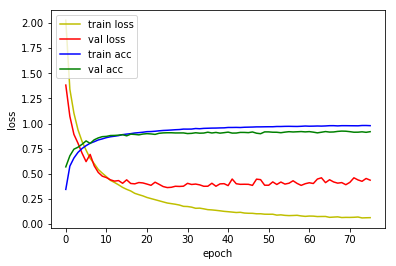

4815/4815 [==============================] - 3s 620us/sample - loss: 0.4431 - acc: 0.8800
Loss: 0.4431484981241751 Accuracy: 0.87995845

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2147 - acc: 0.2780
Epoch 00001: val_loss improved from inf to 1.43896, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_7_conv_checkpoint/001-1.4390.hdf5
36805/36805 [==============================] - 55s 1ms/sample - loss: 2.2146 - acc: 0.2781 - val_loss: 1.4390 - val_acc: 0.5698
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4064 - acc: 0.5439
Epoch 00002: val_loss improved from 1.43896 to 1.01498, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_7_conv_checkpoint/002-1.0150.hdf5
36805/36805 [==============================] - 51s 1ms/sample - loss: 1.4063 - acc: 0.5439 - val_loss: 1.0150 - val_acc: 0.6995
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1935 - acc: 0.9383
Epoch 00024: val_loss did not improve from 0.22775
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1936 - acc: 0.9382 - val_loss: 0.2332 - val_acc: 0.9311
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1829 - acc: 0.9399
Epoch 00025: val_loss improved from 0.22775 to 0.21563, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_7_conv_checkpoint/025-0.2156.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1829 - acc: 0.9399 - val_loss: 0.2156 - val_acc: 0.9408
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1764 - acc: 0.9434
Epoch 00026: val_loss improved from 0.21563 to 0.21265, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_7_conv_checkpoint/026-0.2126.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1764 - acc: 0.9434 - val_los

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0826 - acc: 0.9724
Epoch 00052: val_loss did not improve from 0.18420
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0826 - acc: 0.9724 - val_loss: 0.1923 - val_acc: 0.9527
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0848 - acc: 0.9711
Epoch 00053: val_loss did not improve from 0.18420
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0848 - acc: 0.9711 - val_loss: 0.2023 - val_acc: 0.9506
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0824 - acc: 0.9731
Epoch 00054: val_loss did not improve from 0.18420
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0824 - acc: 0.9731 - val_loss: 0.1892 - val_acc: 0.9534
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0766 - acc: 0.9739
Epoch 00055: val_loss did not improve from 0.18420
36805/36805 [===========

Epoch 82/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0460 - acc: 0.9842
Epoch 00082: val_loss did not improve from 0.18420
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0461 - acc: 0.9841 - val_loss: 0.2474 - val_acc: 0.9509
Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9828
Epoch 00083: val_loss did not improve from 0.18420
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0544 - acc: 0.9828 - val_loss: 0.2099 - val_acc: 0.9560
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0469 - acc: 0.9839
Epoch 00084: val_loss did not improve from 0.18420
36805/36805 [==============================] - 51s 1ms/sample - loss: 0.0470 - acc: 0.9839 - val_loss: 0.2161 - val_acc: 0.9548
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0446 - acc: 0.9850
Epoch 00085: val_loss did not improve from 0.18420
36805/36805 [===========

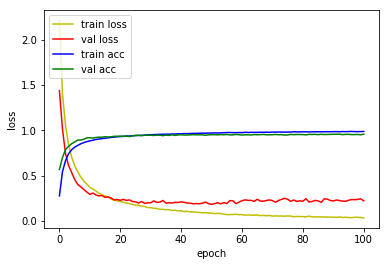

4815/4815 [==============================] - 3s 650us/sample - loss: 0.2270 - acc: 0.9404
Loss: 0.22697225112027003 Accuracy: 0.9403946

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2006 - acc: 0.2885
Epoch 00001: val_loss improved from inf to 1.32087, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_8_conv_checkpoint/001-1.3209.hdf5
36805/36805 [==============================] - 59s 2ms/sample - loss: 2.2004 - acc: 0.2886 - val_loss: 1.3209 - val_acc: 0.6198
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2927 - acc: 0.5854
Epoch 00002: val_loss improved from 1.32087 to 0.79492, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_8_conv_checkpoint/002-0.7949.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 1.2928 - acc: 0.5854 - val_loss: 0.7949 - val_acc: 0.7768
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s -

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1516 - acc: 0.9493
Epoch 00024: val_loss improved from 0.14169 to 0.13725, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_8_conv_checkpoint/024-0.1373.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1516 - acc: 0.9493 - val_loss: 0.1373 - val_acc: 0.9613
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1426 - acc: 0.9543
Epoch 00025: val_loss did not improve from 0.13725
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1426 - acc: 0.9543 - val_loss: 0.1474 - val_acc: 0.9557
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1333 - acc: 0.9564
Epoch 00026: val_loss did not improve from 0.13725
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.1332 - acc: 0.9564 - val_loss: 0.1444 - val_acc: 0.9599
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - lo

Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9800
Epoch 00053: val_loss did not improve from 0.12002
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0599 - acc: 0.9800 - val_loss: 0.1369 - val_acc: 0.9646
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0569 - acc: 0.9803
Epoch 00054: val_loss did not improve from 0.12002
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0568 - acc: 0.9803 - val_loss: 0.1356 - val_acc: 0.9679
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0591 - acc: 0.9797
Epoch 00055: val_loss did not improve from 0.12002
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0591 - acc: 0.9797 - val_loss: 0.1588 - val_acc: 0.9576
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0513 - acc: 0.9820
Epoch 00056: val_loss did not improve from 0.12002
36805/36805 [===========

Epoch 83/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0355 - acc: 0.9885
Epoch 00083: val_loss did not improve from 0.12002
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0355 - acc: 0.9885 - val_loss: 0.1731 - val_acc: 0.9625
Epoch 84/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0326 - acc: 0.9893
Epoch 00084: val_loss did not improve from 0.12002
36805/36805 [==============================] - 53s 1ms/sample - loss: 0.0326 - acc: 0.9893 - val_loss: 0.1594 - val_acc: 0.9655
Epoch 85/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0342 - acc: 0.9889
Epoch 00085: val_loss did not improve from 0.12002
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0342 - acc: 0.9889 - val_loss: 0.1581 - val_acc: 0.9695
Epoch 86/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0319 - acc: 0.9898
Epoch 00086: val_loss did not improve from 0.12002
36805/36805 [===========

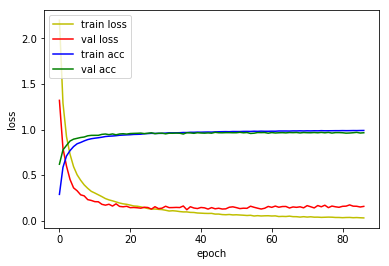

4815/4815 [==============================] - 3s 666us/sample - loss: 0.1595 - acc: 0.9502
Loss: 0.159542751186919 Accuracy: 0.95015574

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.8383 - acc: 0.4091
Epoch 00001: val_loss improved from inf to 0.88675, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_9_conv_checkpoint/001-0.8867.hdf5
36805/36805 [==============================] - 61s 2ms/sample - loss: 1.8382 - acc: 0.4091 - val_loss: 0.8867 - val_acc: 0.7438
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.9004 - acc: 0.7151
Epoch 00002: val_loss improved from 0.88675 to 0.52569, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_9_conv_checkpoint/002-0.5257.hdf5
36805/36805 [==============================] - 54s 1ms/sample - loss: 0.9004 - acc: 0.7151 - val_loss: 0.5257 - val_acc: 0.8486
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - 

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0847 - acc: 0.9715
Epoch 00025: val_loss improved from 0.13069 to 0.12761, saving model to model/checkpoint/1D_CNN_custom_he-uniform_DO_9_conv_checkpoint/025-0.1276.hdf5
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0847 - acc: 0.9715 - val_loss: 0.1276 - val_acc: 0.9620
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0760 - acc: 0.9742
Epoch 00026: val_loss did not improve from 0.12761
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0760 - acc: 0.9742 - val_loss: 0.1456 - val_acc: 0.9555
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0777 - acc: 0.9735
Epoch 00027: val_loss did not improve from 0.12761
36805/36805 [==============================] - 52s 1ms/sample - loss: 0.0777 - acc: 0.9735 - val_loss: 0.1309 - val_acc: 0.9644
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - lo

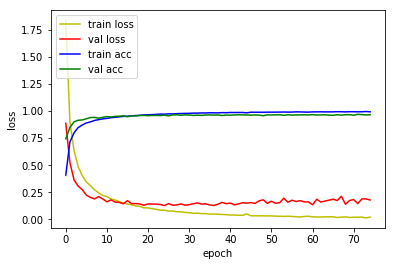

4815/4815 [==============================] - 3s 683us/sample - loss: 0.1838 - acc: 0.9491
Loss: 0.18381216147854568 Accuracy: 0.94911736



In [10]:
for i in range(3, 10):
    base = '1D_CNN_custom_he-uniform_DO'
    model_name = base+'_{}_conv'.format(i)
    model = build_1d_cnn_custom_DO(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)

    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [8]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_he-uniform_DO'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_he-uniform_DO_3_conv Model
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0       

4815/4815 [==============================] - 3s 575us/sample - loss: 0.4431 - acc: 0.8800
Loss: 0.4431484981241751 Accuracy: 0.87995845

1D_CNN_custom_he-uniform_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_63 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_64 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (

4815/4815 [==============================] - 3s 600us/sample - loss: 0.1838 - acc: 0.9491
Loss: 0.18381216147854568 Accuracy: 0.94911736


In [9]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
# base = '1D_CNN_custom_DO'

with open(path.join(log_dir, base)+'_last', 'w') as log_file:
    for i in range(3, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + '000_last.hdf5'

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_he-uniform_DO_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_45 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_45 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_46 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_46 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_47 (Conv1D)           (None, 5333, 64)          20544     
_________________________________________________________________
activation_47 (Activation)   (None

4815/4815 [==============================] - 3s 674us/sample - loss: 0.5081 - acc: 0.8928
Loss: 0.5080954434839489 Accuracy: 0.8928349

1D_CNN_custom_he-uniform_DO_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_63 (Conv1D)           (None, 16000, 64)         384       
_________________________________________________________________
activation_63 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
conv1d_64 (Conv1D)           (None, 16000, 64)         20544     
_________________________________________________________________
activation_64 (Activation)   (None, 16000, 64)         0         
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_65 (Conv1D)           (N

4815/4815 [==============================] - 3s 662us/sample - loss: 0.2724 - acc: 0.9541
Loss: 0.2724173130824275 Accuracy: 0.95410174
